In [49]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [33]:
class RealNVP(nn.Module):

  def __init__(self,nets,nett,mask,prior):
    super(RealNVP, self).__init__()
        
    self.prior = prior
    self.mask = nn.Parameter(mask, requires_grad=False)
    self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
    self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
  
  def f(self,z):
    x = z
    for i in range(len(self.t)):
      x_ = x*self.mask[i]
      s = self.s[i](x_)*(1 - self.mask[i])
      t = self.t[i](x_)*(1 - self.mask[i])
      x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
    return x

  def f_inv(self,x):
    det , z = torch.zeros(x.shape[0]), x
    for i in range(len(self.t)):
       z_ = self.mask[i] * z #According to the formula, we have concat z[0-d] and A[d:end], where A is the affine transformation
       s = self.s[i](z_)*(1 - self.mask[i])
       t = self.t[i](z_)*(1 - self.mask[i])
       z = (1-self.mask[i])* (z - t) * torch.exp(-s) + z_
       det -= s.sum(dim=1)
    return z, det

  def log_prob(self,x):
    z, det = self.f_inv(x)
    return self.prior.log_prob(z) + det

  def sample(self,size):
    z = self.prior.sample((size,1))
    #logp = self.prior.log_prob(z)
    x = self.f(z)
    return x


In [62]:
s = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2), nn.Tanh())
t = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
masks = torch.from_numpy(np.array([[1, 0],[0,1]] * 3).astype(np.float32)) # we will use this to define the number of coupling layers
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow = RealNVP(s, t, masks, prior)

In [63]:
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-3)
for t in range(5001):    
    noisy_moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
    loss = -flow.log_prob(torch.from_numpy(noisy_moons)).mean()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 2.663
iter 500: loss = 0.507
iter 1000: loss = 0.328
iter 1500: loss = 0.450
iter 2000: loss = 0.371
iter 2500: loss = 0.365
iter 3000: loss = 0.509
iter 3500: loss = 0.451
iter 4000: loss = 0.587
iter 4500: loss = 0.479
iter 5000: loss = 0.464


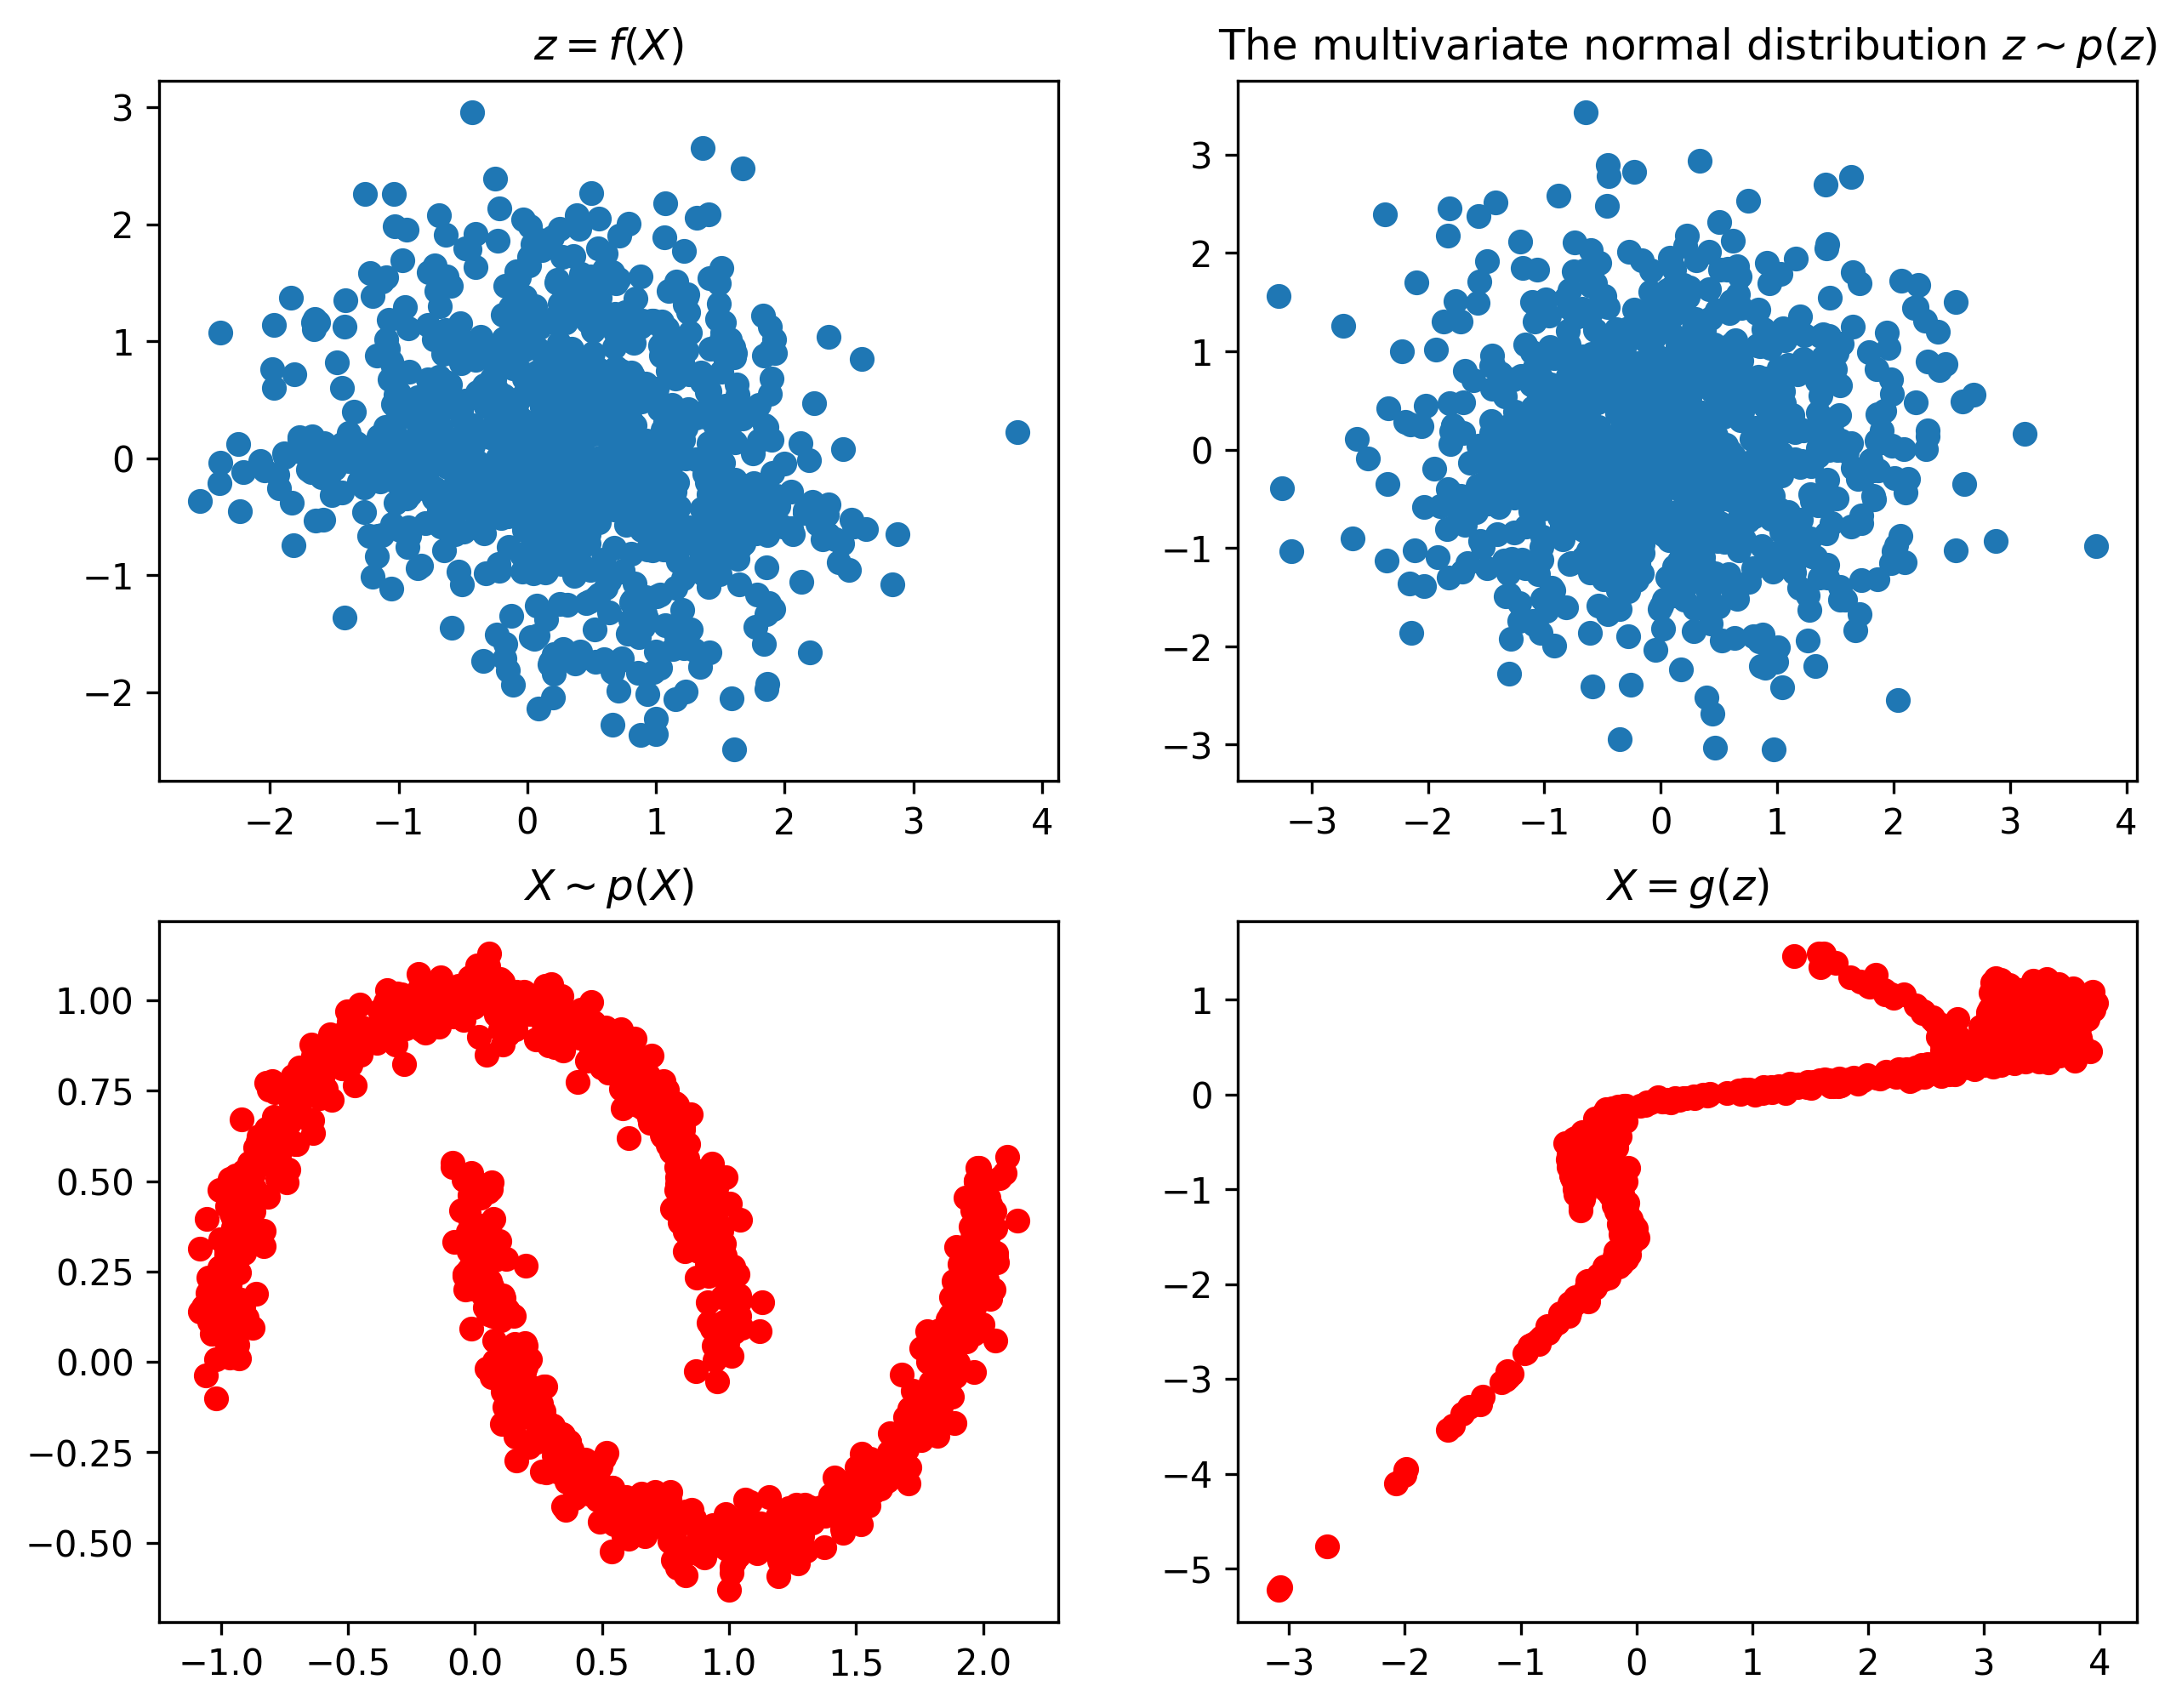

In [65]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f_inv(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'The multivariate normal distribution $z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
#print(x)
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')

plt.savefig("REALNVP")